In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse, io 
import numpy as np
import rpy2.robjects as robjects
import magic
import scprep
from sklearn.decomposition import NMF, non_negative_factorization, PCA
from sklearn.decomposition._nmf import _beta_divergence
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix 


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *
from findK_correction_constd_jk2 import *

import pdb

np.random.seed(123)

In [2]:
Yfile = "../../ebpmf_data_analysis/output/fastTopics_fit/sla_small.txt"
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_fitted.Rds"
vocabfile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_vocab.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"
exper_step1 = "findK-exper-step1.pkl"
exper_step2 = "findK-exper-step2.pkl"

## load data and fitted L, F, s
Y = io.mmread(Yfile)
vocab = np.loadtxt(vocabfile, dtype = str)
readRDS = robjects.r['readRDS']
data = readRDS(datafile)
w_idx = np.asarray(data.rx2('word_idx')).astype(int)
fitted = data.rx2('fit_sub')
F = np.asarray(fitted.rx2('F'))
L = np.asarray(fitted.rx2('L'))
s = np.asarray(fitted.rx2('s'))
p, k = F.shape
n = L.shape[0]

C = L @ F.T
C = C.T @ C / n
Cbar = C / C.sum(axis = 1)[:, None]
w_true = C.sum(axis = 1)


In [3]:
def simulate_multinomial_counts_local(L, F, s):
    n = L.shape[0]
    p = F.shape[0]
    Prob = L.dot(F.T)
    X = np.empty(shape = (n, p))
    for i in range(n):
        X[i,] = np.random.multinomial(s[i], Prob[i,], size = 1).astype(int)

    return X

def get_truth(Cbar, K):
    p = Cbar.shape[0]
    U = np.zeros((p, K))
    R = Cbar.T
    S = np.zeros(K)
    gs = np.zeros((p, K))
    g = (R**2).sum(axis = 0) 
    for k in range(K):
        gs[:, k] = g
        maxSquaredSum = np.max(g)
        maxCol = np.argmax(g)
        S[k] = maxCol
        u = R[:, maxCol].copy()
        u = u / np.sqrt(maxSquaredSum)
        U[:, k] = u
        R = R -  u[:, None] @ (u[:,None].T @ R)
        dg = (Cbar @ u)**2
        g -= dg        

    return S, U, gs

S, U, gs = get_truth(Cbar, k)
S

array([1669., 1888.,  178., 1666.,  490., 1933.])

In [4]:
def comparison(k_, gs, est, se):
    
    truth = gs[:, k_]
    est_ = est[:, k_,:].mean(axis = 1)
    
    plt.hist(truth)
    plt.xlabel("g_truth")
    plt.show()
    

    fig, ax = plt.subplots(1)
    ax.scatter(truth, est_)
    plt.xlim((truth.min(), truth.max()))
    plt.ylim((est_.min(), est_.max()))
    plt.xlabel("g_truth")
    plt.ylabel("g_est") 


    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()
    
    se_emp = np.sqrt(((est[:, k_, :] - est_[:, None])**2).mean(axis = 1))
    se_ = se[:, k_, :].mean(axis = 1)
    
    

    fig, ax = plt.subplots(1)
    ax.scatter(se_emp, se_)
    plt.xlim((se_emp.min(), se_emp.max()))
    plt.ylim((se_.min(), se_.max()))

    plt.xlabel("se_truth")
    plt.ylabel("se_est") 


    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()
    
def comparison2(k_, idx, gs, est, se):
    truth = gs[:, k_]
    est_ = est[:, k_, idx]
    se_ = se[:, k_, idx]
    
    fig, ax = plt.subplots(1)
    ax.scatter(truth, est_)
    plt.xlim((truth.min(), truth.max()))
    plt.ylim((est_.min(), est_.max()))
    plt.xlabel("g_truth")
    plt.ylabel("g_est") 


    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()
    
    est_shrunk = shrink(est_ , np.power(se_, 2))
    fig, ax = plt.subplots(1)
    ax.scatter(truth, est_shrunk)
    plt.xlim((truth.min(), truth.max()))
    plt.ylim((est_shrunk.min(), est_shrunk.max()))
    plt.xlabel("g_truth")
    plt.ylabel("g_est_shrunk") 


    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()
    


step 0


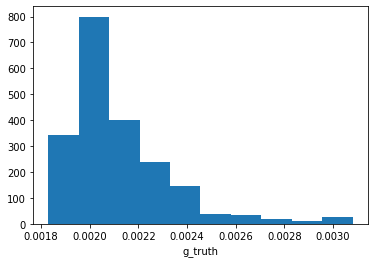

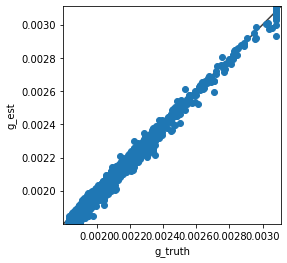

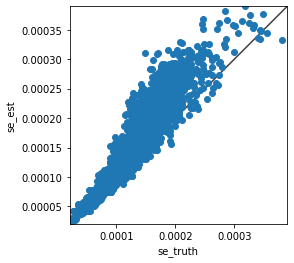

step 1


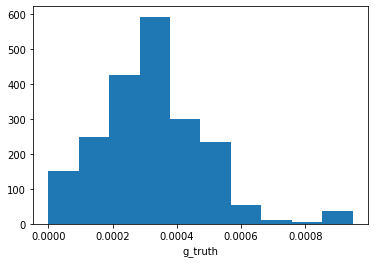

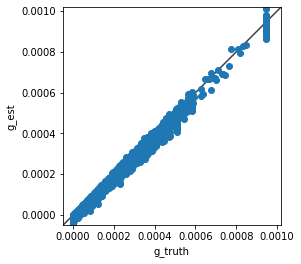

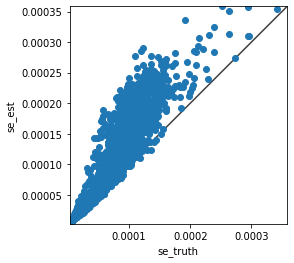

step 2


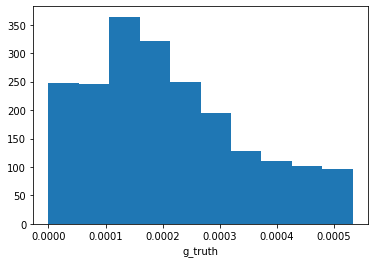

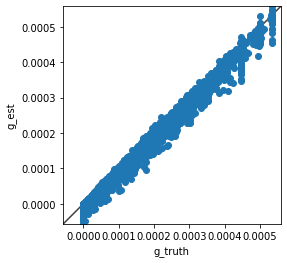

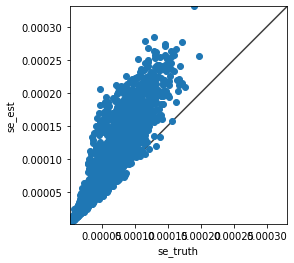

step 3


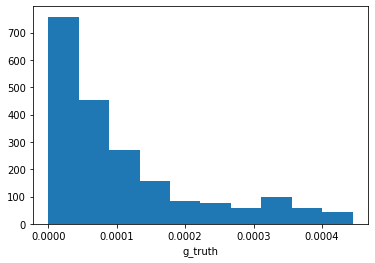

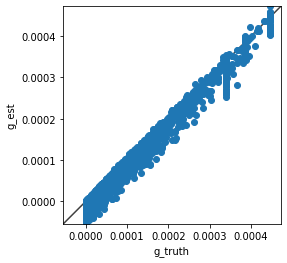

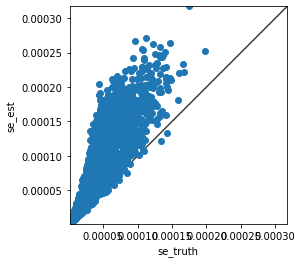

step 4


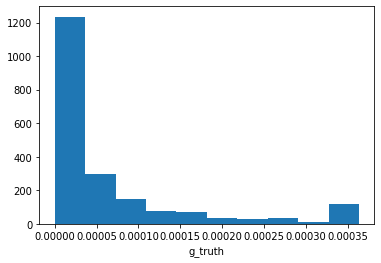

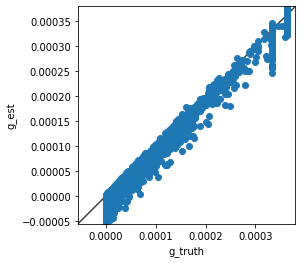

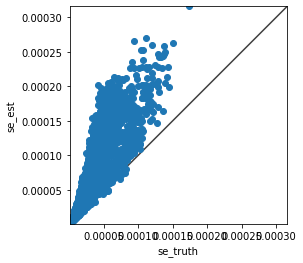

step 5


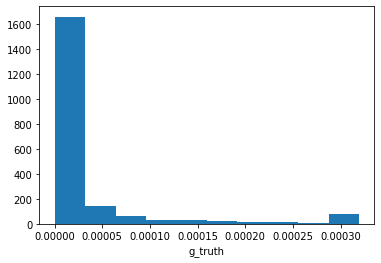

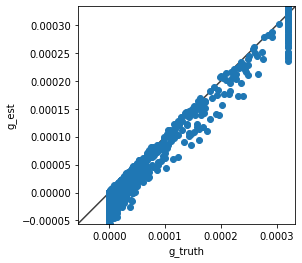

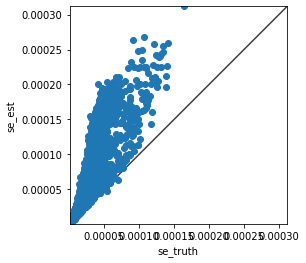

In [5]:
outputfile="findK-exper-constd-jk2.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
se = tmp['se']

for k_ in range(k):
    print(f"step {k_}")
    comparison(k_, gs.copy(), est.copy(), se.copy())



step 0


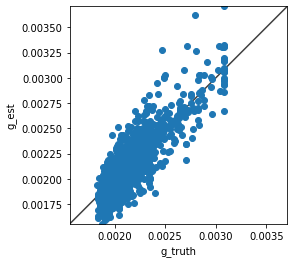

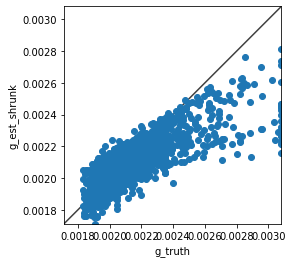

step 1


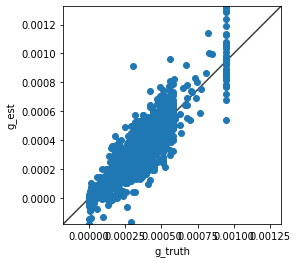

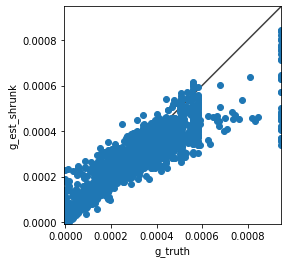

step 2


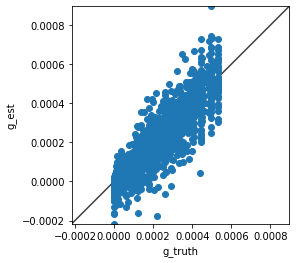

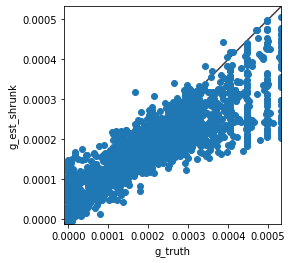

step 3


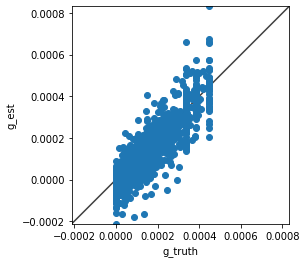

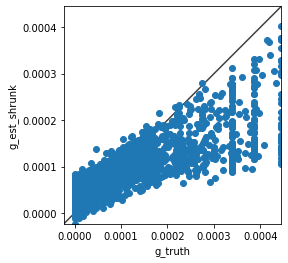

step 4


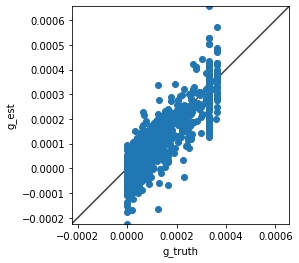

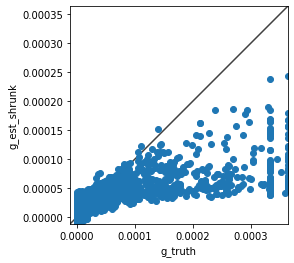

step 5


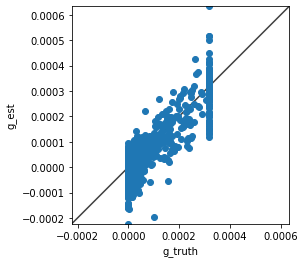

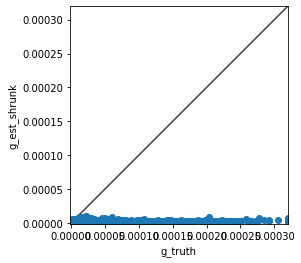

In [6]:
idx = 38
for k_ in range(k):
    print(f"step {k_}")
    comparison2(k_, idx, gs.copy(), est.copy(), se.copy())



## increase $n$

By theorem our estimates should be consistent: bias should go to 0 as $n$ gets larger and larger. However, if the bias is of the order $O(\frac{p^a}{n^b})$ it should not be omitted, so Jack-knife has its drawbacks, as can be seen from above. 

Now let's increase the number of documents ($n$) by 2. As we can see, the bias gets much smaller. If we stick with Jack-knife, we can argue when $n$ larger than $p$, our estimate is good (but vanilla version is still bad; could use that synthethic data as an example). 

step 0


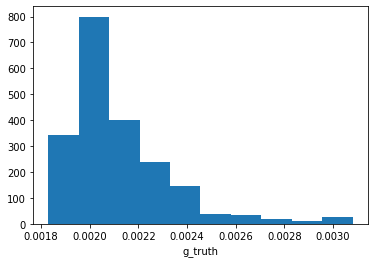

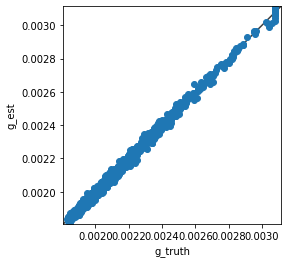

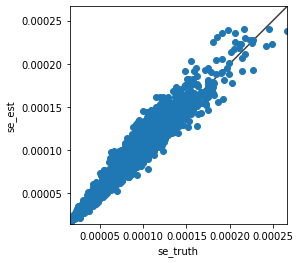

step 1


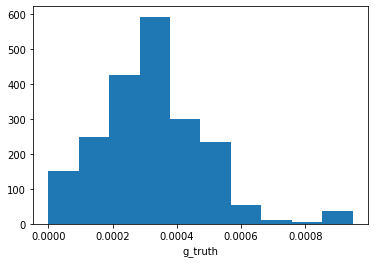

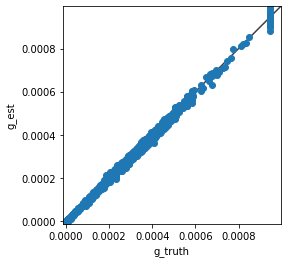

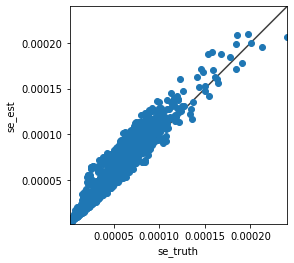

step 2


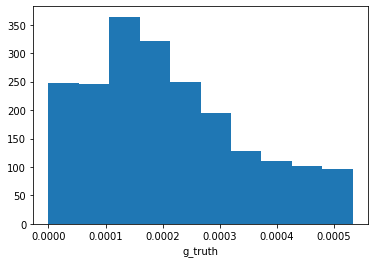

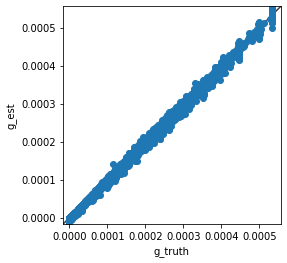

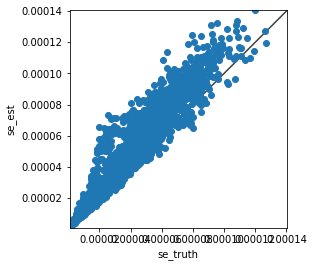

step 3


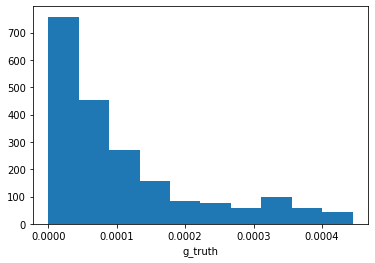

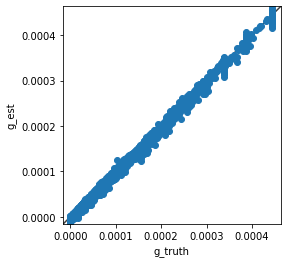

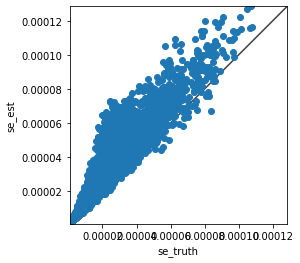

step 4


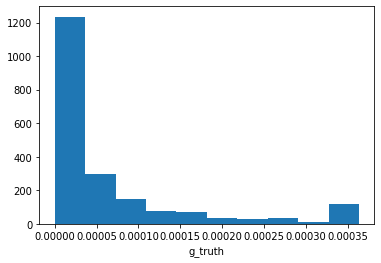

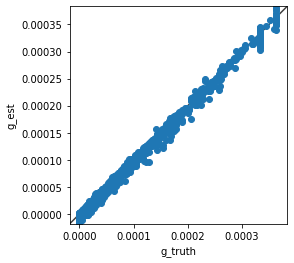

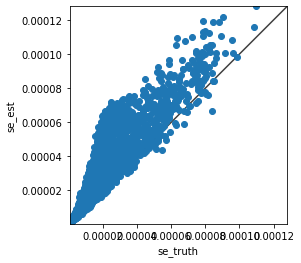

step 5


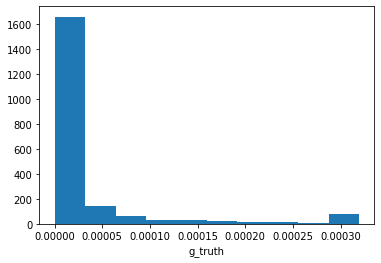

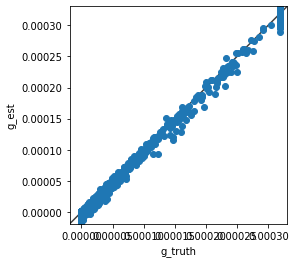

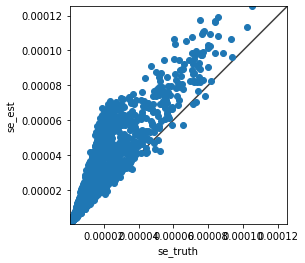

In [7]:
outputfile="findK-exper-constd-jk2-bigger.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
se = tmp['se']

for k_ in range(k):
    print(f"step {k_}")
    comparison(k_, gs.copy(), est.copy(), se.copy())

step 0


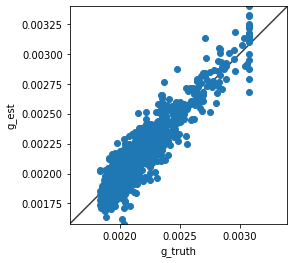

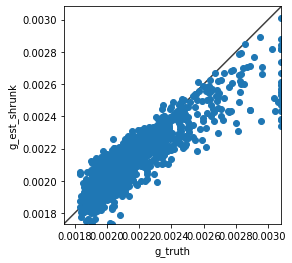

step 1


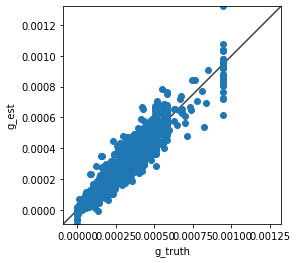

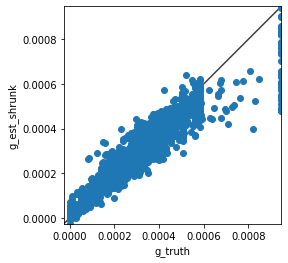

step 2


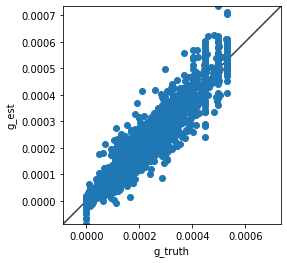

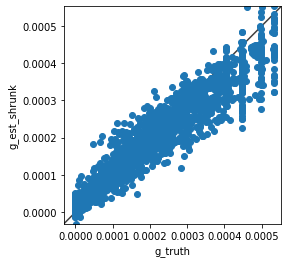

step 3


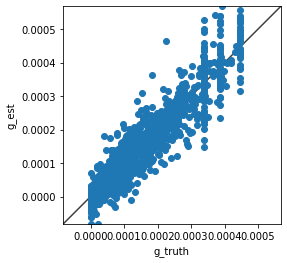

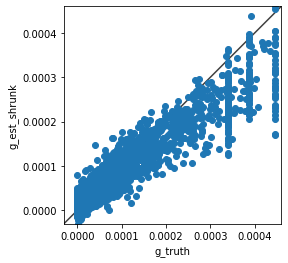

step 4


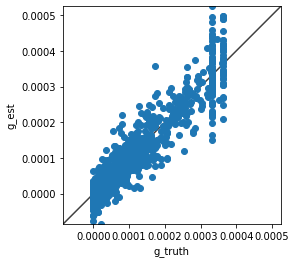

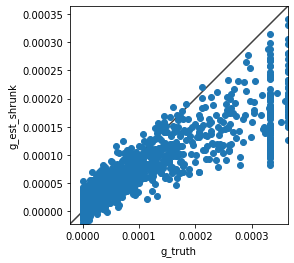

step 5


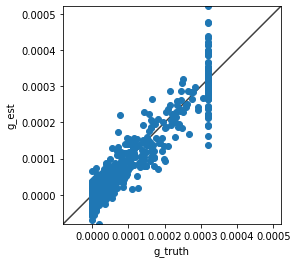

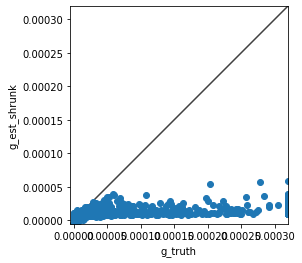

In [8]:
idx = 38
for k_ in range(k):
    print(f"step {k_}")
    comparison2(k_, idx, gs.copy(), est.copy(), se.copy())

### Compare against vanilla findK 

Note vanilla `findK` is not robust so simulated data from different seeds have very different results. Below I picked some bad results. Note that our robust `findK` si quite robust. 

(3207, 2062)
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0842 seconds

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0623 seconds

(array([1669, 1888,  178, 1666,  490, 1933]), array([396., 877., 654., 728., 485., 448.]))
(array([ 787, 1301,  356, 1691, 1386, 1668]), array([34., 23., 14., 14., 21., 16.]))
(array([ 561., 1273., 1926.,  241., 1666.,  490.]), array([157., 283., 123., 341., 728., 485.]))


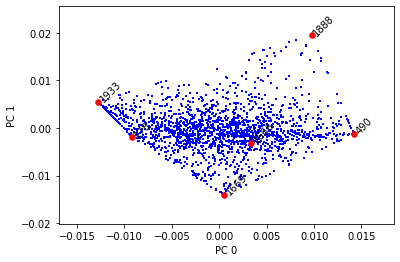

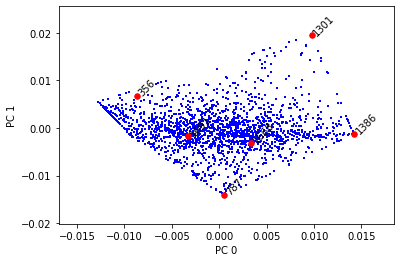

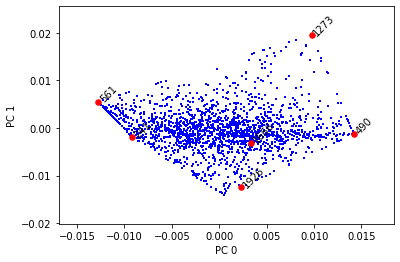

In [9]:
np.random.seed(1)
X = simulate_multinomial_counts_local(L, F, s)
print(X.shape)

C_ = X.T @ X 
np.fill_diagonal(C_, np.diag(C_) -  X.sum(axis = 0))
D = s.mean() * (s.mean() - 1)
C_ /= (D * n)
Cbar_ = C_ / C_.sum(axis = 1)[:, None]

S0, diagR0, _ = findS(Cbar, k)
S1, diagR1, _ = findS(Cbar_, k)
S2, diagR2 = findS_correction_jk(X, Cbar_, C_, k)

print((S0, X.sum(axis = 0)[S0.astype(int)]))
print((S1, X.sum(axis = 0)[S1.astype(int)]))
print((S2, X.sum(axis = 0)[S2.astype(int)]))



Cbar_pj = pca_proj(Cbar)
vis_extremal_pca(Cbar_pj, S0.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S1.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S2.astype(int), [0, 1], annotate=True, fontsize=10)

### use $2n$

(6414, 2062)
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0674 seconds

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0628 seconds

(array([1669, 1888,  178, 1666,  490, 1933]), array([ 873., 1749., 1244., 1464., 1113.,  801.]))
(array([1066, 1039,  253, 1618,  768, 1348]), array([37., 40., 30., 40., 38., 20.]))
(array([1669.,  447.,  552., 1366., 1933.,  490.]), array([ 873.,  202.,  234.,  306.,  801., 1113.]))


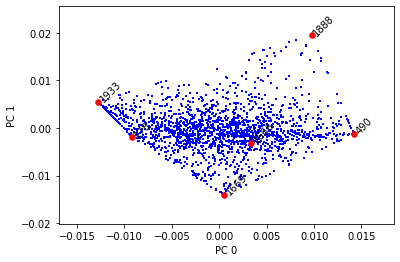

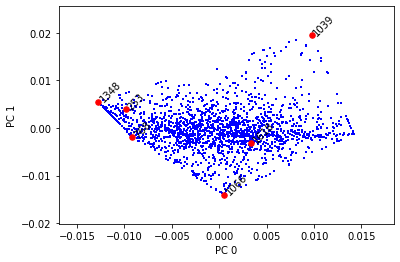

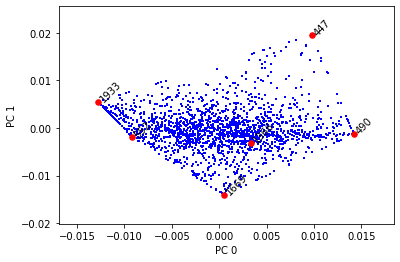

In [10]:
np.random.seed(1)
L = np.concatenate([L, L])
n = L.shape[0]
s = np.asarray(fitted.rx2('s'))
s = np.repeat(np.round(s.mean()), n) ## equal length

X = simulate_multinomial_counts_local(L, F, s)
print(X.shape)

C_ = X.T @ X 
np.fill_diagonal(C_, np.diag(C_) -  X.sum(axis = 0))
D = s.mean() * (s.mean() - 1)
C_ /= (D * n)
Cbar_ = C_ / C_.sum(axis = 1)[:, None]

S0, diagR0, _ = findS(Cbar, k)
S1, diagR1, _ = findS(Cbar_, k)
S2, diagR2 = findS_correction_jk(X, Cbar_, C_, k)

print((S0, X.sum(axis = 0)[S0.astype(int)]))
print((S1, X.sum(axis = 0)[S1.astype(int)]))
print((S2, X.sum(axis = 0)[S2.astype(int)]))

Cbar_pj = pca_proj(Cbar)
vis_extremal_pca(Cbar_pj, S0.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S1.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S2.astype(int), [0, 1], annotate=True, fontsize=10)